## Execute PID Control

### Setup and Connect

In [40]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False
ble = get_ble_controller()
ble.connect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2022-03-14 20:15:22,936 | INFO     |: Already connected to a BLE device


### Define Robot Controller Class

In [41]:
class RobotControl():
    # Initialize Function
    def __init__(self, ble):
        self.ble = ble
        self.notifiers_on = False
        self.TOF_HISTORY_LEN = 40
        self.IMU_HISTORY_LEN = 300

        # A variable to store the latest sensor value
        self.latest_tof_front_reading = None
        
        # A list to store the history of all the sensor values
        # Each item in the list is a tuple (value, time)
        # WARNING: The list could grow really fast; you need to deal with this accordingly.
        self.tof1_readings = [] # TODO change these to a bounded queue
        self.tof2_readings = []
        self.imu_readings = []
        self.bot_pid_debug = []
        
        # A variable to store the latest imu reading
        self.latest_imu_reading = None
        
        # Activate notifications (if required)
        self.setup_notify()
    
    # A function to activate various notifications (if required)
    def setup_notify(self):
        # Code to setup various notify events
        # Ex:
        ble.start_notify(ble.uuid['RX_TOF1'], self.tof1_callback_handler)
        ble.start_notify(ble.uuid['RX_TOF2'], self.tof2_callback_handler)
        ble.start_notify(ble.uuid['RX_IMU'], self.imu_callback_handler)
        ble.start_notify(ble.uuid['RX_MOTOR_PID'], self.motor_pid_callback_handler)
        self.notifiers_on = True

    def stop_notify(self):
        ble.stop_notify(ble.uuid['RX_TOF1'])
        ble.stop_notify(ble.uuid['RX_TOF2'])
        ble.stop_notify(ble.uuid['RX_IMU'])
        ble.stop_notify(ble.uuid['RX_MOTOR_PID'])
        self.notifiers_on = False
    
    def tof1_callback_handler(self, uuid, byte_array):
        self.tof1_readings.append( self.ble.bytearray_to_float(byte_array) )

    def tof2_callback_handler(self, uuid, byte_array):
        self.tof2_readings.append( ( self.ble.bytearray_to_float(byte_array), time.time() ) )
    
    def imu_callback_handler(self, uuid, byte_array):
        self.imu_readings.append( (self.ble.bytearray_to_string(byte_array), time.time()) )

    def motor_pid_callback_handler(self, uuid, byte_array):
        self.bot_pid_debug.append( self.ble.bytearray_to_float(byte_array) )

    # An example function to fetch the front TOF sensor reading
    # Here we assume RX_TOF1 is a valid UUID defined in connection.yaml and
    # in the Arduino code as well
    def get_front_tof(self):
        ble.send_command(CMD.GET_FRONT_TOF, None)
        return self.tof1_readings[-1]

    
    # An example function to fetch the IMU readings as a string
    # Here we assume RX_IMU is a valid UUID defined in connection.yaml and
    # in the Arduino code as wellt
    # def get_imu(self):
    #     self.latest_imu_reading = self.ble.receive_string(self.ble.uuid['RX_IMU'])
    #     pass
    
    def start_pid(self, setpoint):
        ble.send_command(CMD.START_PID, setpoint)

    def stop_pid(self):
        ble.send_command(CMD.STOP_PID, None)

    # A function to instruct the robot to move forward
    def move_forward(self, speed):
        ble.send_command(CMD.MOVE_FORWARD, speed)
    
    # A function to stop robot motion
    def stop(self):
        ble.send_command(CMD.STOP, None)

    def start_data_collection(self):
        ble.send_command(CMD.START_DATA_COLLECTION, None)
    
    def stop_data_collection(self):
        temp_notif = self.notifiers_on
        if not temp_notif:
            self.setup_notify()
        ble.send_command(CMD.STOP_DATA_COLLECTION, None)
        for i in range(self.TOF_HISTORY_LEN):
            ble.send_command(CMD.GET_TOF1_DATA, i)
            ble.send_command(CMD.GET_PID_DATA, i)
        if not temp_notif:
            self.stop_notify()


### Run PID

In [44]:
bot = RobotControl(ble)
bot.stop_notify()
bot.start_data_collection()
bot.start_pid(0.05)
time.sleep(2)
bot.stop_pid()
bot.stop_data_collection()
bot.stop()

print(f"PID: {bot.bot_pid_debug}")
print(f"TOF: {bot.tof1_readings}")

PID: [61.0, 199083.0, 61.0, 199176.0, 60.0, 199280.0, 58.0, 199378.0, 57.0, 199480.0, 54.0, 199589.0, 50.0, 199682.0, 46.0, 199792.0, 42.0, 199884.0, 37.0, 199999.0, 32.0, 200092.0, 26.0, 200207.0, 22.0, 200299.0, 18.0, 200397.0, 14.0, 200504.0, 11.0, 200598.0, 8.0, 200706.0, 6.0, 200803.0, 5.0, 200908.0, 5.0, 201003.0, 5.0, 201108.0, 0.0, 201203.0, 0.0, 201312.0, 0.0, 201408.0, 0.0, 201512.0, 0.0, 201605.0, 0.0, 201710.0, 0.0, 201805.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
TOF: [441.0, 199083.0, 1523.0, 199176.0, 1522.0, 199280.0, 1524.0, 199378.0, 1510.0, 199480.0, 1479.0, 199589.0, 1440.0, 199682.0, 1380.0, 199792.0, 1318.0, 199884.0, 1236.0, 199999.0, 1148.0, 200092.0, 1042.0, 200207.0, 941.0, 200299.0, 836.0, 200397.0, 746.0, 200504.0, 670.0, 200598.0, 593.0, 200706.0, 531.0, 200803.0, 477.0, 200908.0, 439.0, 201003.0, 414.0, 201108.0, 406.0, 201203.0, 407.0, 201312.0, 406.0, 201408.0, 404.0, 201512

### Visualize

In [34]:
tof_times = []
tof_vals = []
pid_vals = []
pid_times = []

last_data_point = 0
for i in reversed(range(len(bot.tof1_readings))):
  if i % 2 == 0: continue
  if bot.tof1_readings[i] == 0: continue
  last_data_point = i
  break
print(last_data_point)

for i,val in enumerate(bot.tof1_readings[:last_data_point+1]):
  if i % 2 == 0:
    tof_vals.append(val) # Even index, so this is a distance
  else:
    tof_times.append(val)

for i,val in enumerate(bot.bot_pid_debug[:last_data_point+1]):
  if i % 2 == 0:
    pid_vals.append(val) # Even index, so this is a distance
  else:
    pid_times.append(val)

43


### Time of Flight Reading vs Time

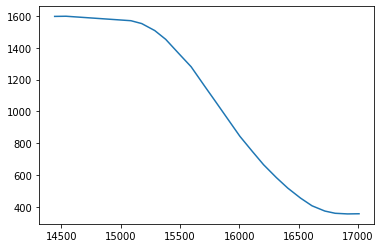

In [35]:
plt.plot(tof_times, tof_vals)

### PID Input vs Time

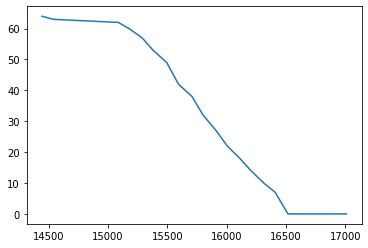

In [36]:
plt.plot(pid_times, pid_vals)